# Model Selection
- During model training, the Australia dataset consistently showed poor r-squared values.
- To test if this was just an anomaly of the split, we run 1000 random split trials and build an r-squared distribution.
- We use only one feature (# drinks) as this was shown to be the strongest feature in exploratory data analysis.

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter, MaxNLocator
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import pickle
import sys
sys.path.append('../src')
import model_training_functions

In [10]:
def rsquared_distribution(dataset, features, target_column_name, iterations, title):
    X = dataset[features]
    Y = dataset[target_column_name]

    r2_scores = []

    for _ in range(iterations):
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
        model = LinearRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        r2_scores.append(r2)

    r2_scores = np.array(r2_scores)
    mean_r2 = np.mean(r2_scores)
    lower_bound = np.percentile(r2_scores, 1)
    upper_bound = np.percentile(r2_scores, 99)
    range_padding = (upper_bound - lower_bound) * 0.1 # what is this?

    # Plot
    plt.figure(figsize=(8,5))
    num_bins = min(100, int(np.sqrt(iterations)))
    plt.hist(r2_scores, bins=num_bins, edgecolor='black')
    plt.xlabel('R² Score')
    plt.ylabel('Frequency')
    plt.title(f'{title} Distribution of R² Values over {iterations} Random Split Trials')

    plt.axvline(mean_r2, color='red', linestyle='dashed', linewidth=2, label=f'Mean R²: {mean_r2:.4f}')
    plt.legend()

    plt.xlim(lower_bound - range_padding, upper_bound + range_padding)

    plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=10, prune='both'))
    plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    plt.tight_layout()
    plt.savefig(f'../output/{title}_rsquared_distribution.png', dpi=300)

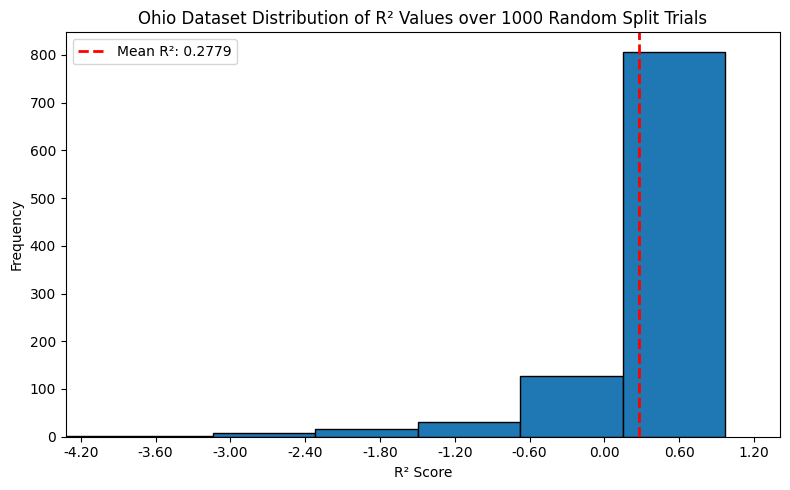

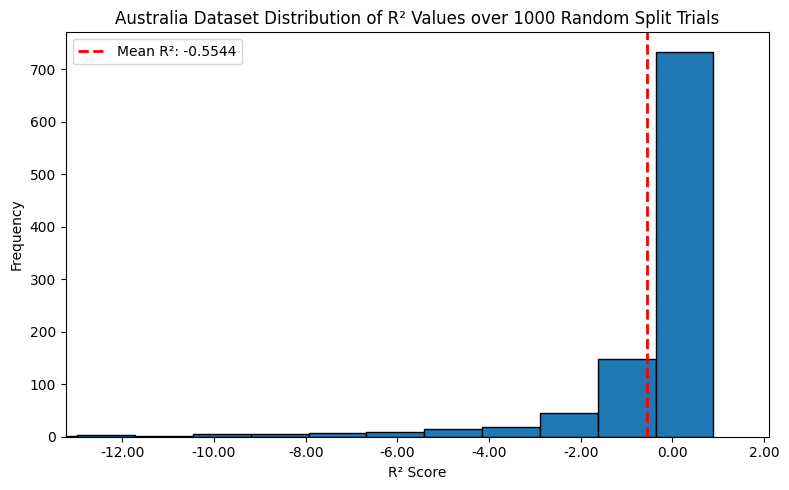

In [11]:
ohio_dataset = pd.read_csv('../data/processed/ohio_bac_dataset_processed.csv')
australia_dataset = pd.read_csv('../data/processed/australia_bac_dataset_processed.csv')
rsquared_distribution(ohio_dataset, ['Ethanol_grams'], 'BAC', 1000, 'Ohio Dataset')
rsquared_distribution(australia_dataset, ['Ethanol_grams'], '1hr-BAC', 1000, 'Australia Dataset')

## Results & Interpretation
We find Australia dataset has consistently poor r-squared values. We suspect this is due to high variance in the data due to poorly controlled experimental conditions.

## Conclusion
Given the same modeling conditions, the Australia Dataset is inherently harder to predict than Ohio Dataset. Thus, our final model will be based on the Ohio Dataset.

In [12]:
# save Ohio model
ohio_bac_dataset = pd.read_csv('../data/processed/ohio_bac_dataset_processed.csv')
model = model_training_functions.build_model(ohio_bac_dataset, ['Bodyweight_grams', 'Ethanol_grams'], 'BAC')
model_training_functions.save_model_summary(model, ohio_bac_dataset[['Bodyweight_grams', 'Ethanol_grams']], ohio_bac_dataset['BAC'], '../output/ohio_bac_model_summary.txt')
model_training_functions.plot_model_results(model, ohio_bac_dataset, ['Bodyweight_grams', 'Ethanol_grams'], 'BAC')
model_filename = '../output/ohio_bac_model.pkl'
with open(model_filename, 'wb') as f:
    pickle.dump(model, f)

In [13]:
# Save a reversed model (predicting Ethanol_grams from BAC and Bodyweight_grams) for the website
# Didn't have time to properly train
model = model_training_functions.build_model(ohio_bac_dataset, ['Bodyweight_grams', 'BAC'], 'Ethanol_grams')
model_filename = '../website/ohio_ethanol_model.pkl'
with open(model_filename, 'wb') as f:
    pickle.dump(model, f)